In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import numpy.linalg 
from tqdm import tqdm
import numba
from numba import njit,vectorize, jit
from itertools import product, permutations
import time
import scipy
import matplotlib.pyplot as plt

import Estimators
import Unsupervised
import Kernels as K 

In [3]:
sig2 = 1
d = 1.1
c = 0

## Some useful functions

#### Kernels functions for _mat_100 data

In [4]:
@njit
def PolynomialKernel(x,y): 
    return (x.dot(y)+c)**d

@njit
def GaussianKernel(x,y,sig2 = 1):
    return np.exp(-numpy.linalg.norm(x-y)**2/(2*sig2))

@njit
def LinearKernel(x,y): 
    return x.dot(y)

@njit
def Laplace_kernel(x, y, gamma=1):
    return 0.5 * np.exp(-gamma * np.linalg.norm(x-y))

#### Data mportation

In [5]:
def importation_mat_100(): 
    '''
    import all the (float) data and puts them in a list X_train_100. X_train_100[0] will be X_train_mat_100 and so on. 
    '''
    X_train_100 = []
    X_test_100 = []
    Y_train = []
    for i in range(3): 
        xtrain = pd.read_csv('data/Xtr'+str(i)+'_mat100.csv',delimiter= ',', header= None)
        xtrain = np.squeeze(xtrain.to_numpy())
        X_train_100.append(xtrain)
    
        xtest = pd.read_csv('data/Xte'+str(i)+'_mat100.csv',delimiter= ',', header= None)
        xtest = np.squeeze(xtest.to_numpy())
        X_test_100.append(xtest)
    
        Y_train.append(pd.read_csv('data/Ytr'+str(i)+'.csv',delimiter= ',')['Bound'].to_numpy())
    return X_train_100,X_test_100,Y_train

def importation(): 
    '''
    import all the (string) data and puts them in a list X_train. X_train[0] will be X_train_0 and so on. 
    '''
    X_train = []
    X_test = []
    Y_train = []
    for i in range(3): 
        xtrain = pd.read_csv('data/Xtr'+str(i)+'.csv',delimiter= ',', header= None)
        xtrain = xtrain.iloc[1:,1].to_numpy()
        X_train.append(xtrain)
    
        xtest = pd.read_csv('data/Xte'+str(i)+'.csv',delimiter= ',', header= None)
        xtest = xtest.iloc[1:,1].to_numpy()
        X_test.append(xtest)
    
        Y_train.append(pd.read_csv('data/Ytr'+str(i)+'.csv',delimiter= ',')['Bound'].to_numpy())
    return X_train,X_test,Y_train

X_train,X_test,Y_train = importation()
X_train_100, X_test_100,Y_train = importation_mat_100()


'''
we do this so that we compute the Dictionnary of phi_spectrum easier. 
'''
X_traintest = []
for i in range(3): 
    X_traintest.append(np.concatenate((X_train[i],X_test[i])))

#### Some functions to build the Kernel matrices Kern_train and Kernel_test

In [6]:
def to_Kernel_train(X, Kernel): 
    length = X.shape[0]
    mat_K = np.zeros((length,length))
    for i in tqdm(range(length)):
        x_i = np.squeeze(X[i])
        for j in range(i,length): 
            x_j = np.squeeze(X[j])
            value = Kernel(x_i,x_j)
            mat_K[i,j] = value
            mat_K[j,i] = value 
    return mat_K

#@njit 
def to_Kernel_test(Xtrain,Xtest,Kernel):
    '''
    takes the training data input Xtrain and the test data Xtest and computes the Kernel_test. 
    
    The length of the resulting Kernel_test will be (nb_traing_samples, nb_testing_samples) 
    '''
    length_train = Xtrain.shape[0]
    length_test = Xtest.shape[0]
    bimat_K = np.zeros((length_train,length_test))
    for i in tqdm(range(length_train)):
        x_i = np.squeeze(Xtrain[i])
        for j in range(length_test): 
            x_j = np.squeeze(Xtest[j])
            bimat_K[i,j] = Kernel(x_i,x_j)
    return bimat_K

def standardize(K): 
    '''
    standardize the given matrix K
    '''
    U = np.full(K.shape,1/K.shape[0])
    I = np.eye(K.shape[0])
    return (I-U)@K@(I-U)

#### Some Kernels for string data

In [7]:
# Compute phi for Spectrum kernel
def phi_spectrum(x,k,U):
    """U: list of the sequences of size k to look for in x"""
    phi_spec = np.zeros(len(U))
    for j, u in enumerate(U):
        for i in range(len(x)-k+1):
            if x[i:i+k] == u:
                phi_spec[j] +=1
    return phi_spec

#Compute phi for Substring kernel
def l(i):
    return i[-1] - i[0] + 1

def I(k,n):
    I = set()
    for ele in permutations(range(0,n),k):
        I.add(tuple(sorted(list(ele))))
    return list(I)

def phi_substring(x,k,U,lamb=0.5): #fonctionne (testé avec l'exemple page 392)
    """U: list of the sequences of size k to look for in x"""
    phi = np.zeros(len(U))
    I_kn = I(k,len(x))
    for j, u in enumerate(U):
        for i in I_kn:
            x_i = "".join([x[idx]  for idx in i])
            if x_i==u:
                phi[j] += lamb**l(i)
    return phi


def make_dict_phi(X, phi,k):
    U = [''.join(letter) for letter in product('ACGT', repeat=k)]
    phi_dict = {seq:phi(seq,k,U) for seq in tqdm(X)}
    return phi_dict

## Building dictionnaries

In [24]:
##CONSTRUCTION DES DICTIONNAIRES. On fait ça pour eviter de les recalculer à chaque fois
## just uncomment the ones you want to compute. (and uncomment the next line also). for k=8, takes about 2 hours. 
dict_spectrum_traintest = [0]*10

#dict_spectrum_traintest[3] = make_dict_phi(X_traintest[0],phi_spectrum,3)
#dict_spectrum_traintest[4] = make_dict_phi(X_traintest[0],phi_spectrum,4)

#dict_spectrum_traintest[5] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,5)
#dict_spectrum_traintest[6] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,6)
#dict_spectrum_traintest[7] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,7)
#dict_spectrum_traintest[8] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,8)
#dict_sub_traintest_2 = make_dict_phi(X_traintest[0], phi_substring,2)

dict_sub_traintest_3 = make_dict_phi(X_traintest[0], phi_substring,3)

  0%|▎                                                                             | 11/3000 [01:17<5:44:29,  6.92s/it]

KeyboardInterrupt: 

In [9]:
def make_K_spectrum(k): 
    '''
    template function to build a K_spectrum_function. 
    We need to have one function for each kernel functionin order to compute efficiently the Kernel matrix (it makes code fluent). 
    '''
    def K_spectrum(x,y): 
        value = np.sum([dict_spectrum_traintest[k][str(x)] * dict_spectrum_traintest[k][str(y)]])
        return value 
    return K_spectrum

K_spectrum_5 = make_K_spectrum(5)
K_spectrum_6 = make_K_spectrum(6)
K_spectrum_7 = make_K_spectrum(7)
K_spectrum_8 = make_K_spectrum(8)

## Computation of the Kernel_train and Kernel_test

In [10]:
def get_first_Kernel(Kernel): 
    '''
    gets the first Kernel_train and Kernel_test. This is only for testing one model one the first dataset. 
    '''
    K_train = to_Kernel_train(X_train[0], Kernel)
    K_test = to_Kernel_test(X_train[0], X_test[0], Kernel)
    return K_train,K_test 

def get_list_Kernels_100(Kernel) : 
    '''
    get two list ok Kernel. For list_K_train, each element i is the Kernel_train computed with kernel for dataset i. Same for list_K_test
    args : 
        
        Kernel : a Kernel function, for example K_sprectum_6
        
    returns : 
    
            List_Kernel_train : a list where each element i is the Kernel_train computed with Kernel for dataset i.
            
            List_Kernel_test : a list where each element i is the Kernel_test computed with Kernel for dataset i. 
            
    Only works for Kernel that takes as input floats, for example GaussianKernel
    '''
    list_K_train = list()
    list_K_test = list()
    for i in tqdm(range(3)): 
        list_K_train.append(to_Kernel_train(X_train_100[i], Kernel))
        list_K_test.append(to_Kernel_test(X_train_100[i],X_test_100[i], Kernel))
    return list_K_train,list_K_test

def get_list_Kernels(Kernel) : 
    '''
    We will mostly use this function. 
    get two list ok Kernel. For list_K_train, each element i is the Kernel_train computed with kernel for dataset i. Same for list_K_test
    args : 
        
        Kernel : a Kernel function, for example K_sprectum_6
        
    returns : 
    
            List_Kernel_train : a list where each element i is the Kernel_train computed with Kernel for dataset i.
            
            List_Kernel_test : a list where each element i is the Kernel_test computed with Kernel for dataset i. 
            
    Only works for Kernel that takes as input strings, for example K_spectrum. 
    
    '''
    list_K_train = list()
    list_K_test = list()
    for i in tqdm(range(3)): 
        list_K_train.append(to_Kernel_train(X_train[i], Kernel))
        list_K_test.append(to_Kernel_test(X_train[i],X_test[i], Kernel))
    return list_K_train,list_K_test

Load a precompute Kernel:

In [32]:
Kernel_train_spectrum_6 = load('data\PrecomputeKernels\Kernel_train_spectrum_6.npy')

Or calculate it, if it is not already done : Each cell tkaes about 5 minutes to compute. 

Don't forget to save it

In [ ]:
list_K_train_spectrum_5, list_K_test_spectrum_5 = get_list_Kernels(K_spectrum_5)  

In [12]:
Kernel_train_spectrum_6, Kernel_test_sprectum_6 = get_list_Kernels(K_spectrum_6)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:13<00:00,  2.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:15<00:00,  2.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:39<00:00,  3.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:04:08<00:00, 1282.96s/it]


In [ ]:
list_K_train_spectrum_6, list_K_test_spectrum_6 = get_list_Kernels(K_spectrum_6)  

In [ ]:
list_K_train_spectrum_7, list_K_test_spectrum_7 = get_list_Kernels(K_spectrum_7)  

In [11]:
list_K_train_spectrum_8, list_K_test_spectrum_8 = get_list_Kernels(K_spectrum_8)  

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:09<00:00,  5.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:16<00:00,  5.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:14<00:00,  5.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [37:19<00:00, 746.35s/it]


In [12]:
#enregistrer les données:
from numpy import load
from numpy import save
save('data\PrecomputeKernels\list_K_train_spectrum_8.npy', list_K_train_spectrum_8)
save('data\PrecomputeKernels\list_K_test_spectrum_8.npy', list_K_test_spectrum_8)

## Hyperparameter tuning

In [13]:
def grid_search_cv(model, Kernel_train, Y_train, parameters): 
    '''
    grid search cv. 
    put the model you want, for example Estimators.KRR(), the Kernel_train you want to train on, the labels Y_train
    and the list of parameters (parameters) you want to try. 
    
    Will print the best parameter with the score associated. 
    '''
    scores = list()
    for parameter in parameters : 
        model.set_parameter(parameter)
        scores.append(model.cross_val(Kernel_train,Y_train, 5))
        print('We have tested  : ', np.round(parameter, 6))
    arg_max = np.argmax(np.array(scores))
    print('###########BEST_PARAM = ',np.round(parameters[arg_max], 6), 'with score :', scores[arg_max])
    return parameters[arg_max]

In [ ]:
KRR_spectrum_7 = Estimators.KRR(Kernel = K_spectrum_7)
parameters = np.linspace(0.0001,0.2,30)
grid_search_cv(KRR_spectrum_7, list_K_train_spectrum_7[2], Y_train[2], parameters)

In [23]:
svm_spectrum_8 = Estimators.SVM()
parameters = np.linspace(0.01,0.041,8)
#parameters = 10**np.linspace(-5,2,30)
grid_search_cv(svm_spectrum_8, list_K_train_spectrum_8[2], Y_train[2], parameters)

#Best param SVM:
#with spectrum 6:
#For set 0: BEST_PARAM =  0.004642 with score : 0.648
#For set 1: BEST_PARAM =  0.001728 with score : 0.6545
#For set 2: BEST_PARAM =  0.012857 with score : 0.7484 

#Pr SVM_2:
#For set 0: BEST_PARAM =  0.002756 with score : 0.642
#For set 1: BEST_PARAM =  0.0067 with score : 0.653
#For set 2: BEST_PARAM =  0.014571 with score : 0.7465

#With spectrum 8:
#For set 0: BEST_PARAM =  0.007091 with score : 0.665
#For set 1: BEST_PARAM =  0.000161 with score : 0.6435
#For set 2: BEST_PARAM =  0.027714 with score : 0.728

5it [00:12,  2.55s/it]


Score :  0.7235
We have tested  :  0.01


5it [00:12,  2.48s/it]


Score :  0.7235
We have tested  :  0.014429


5it [00:12,  2.51s/it]


Score :  0.719
We have tested  :  0.018857


5it [00:12,  2.48s/it]


Score :  0.7264999999999999
We have tested  :  0.023286


5it [00:12,  2.48s/it]


Score :  0.728
We have tested  :  0.027714


5it [00:12,  2.44s/it]


Score :  0.724
We have tested  :  0.032143


5it [00:12,  2.49s/it]


Score :  0.7215
We have tested  :  0.036571


5it [00:12,  2.44s/it]


Score :  0.72
We have tested  :  0.041
###########BEST_PARAM =  0.027714 with score : 0.728


0.027714285714285712

## Downloading results

In [29]:
def download_results(model,list_Kernel_train,list_Kernel_test, parameters, name_dossier):
    '''
    Download the predictions of the 3 datasets, where the model will be trained with the Kernel_train you give and the parameter you give. 
    
    args : 
            model : a model for example Estimators.KRR()
            list_Kernel_train : a list where the element i is the Kernel_train of the i dataset (not any Kernel_train, the one computed with the Kernel of your choice)
            list_Kernel_test : a list where the element i is the Kernel_test of the i dataset (not any Kernel_test, the one computed with the Kernel of your choice)
            parameters : a list of parameters you want to try. 
            name_dossier : your predictions will be stocked in the dossier 'predictions_KM'+name_dossier+'.csv'
            
    returns : None. 
    
    All your predictions will be directly saved. 
    '''
    
    Y_predicted = []
    for i in range(3): 
        model.set_parameter(parameters[i])
        model.fit(list_Kernel_train[i], Y_train[i])
        Y_predicted.append(model.predict(list_Kernel_test[i])*1)
        print('Model {} Predicted'.format(i))

    d = { 'Id' : np.arange(3000), 'Bound' : np.concatenate(Y_predicted)}
    out = pd.DataFrame(data=d)
    out.to_csv('predictions_KM'+name_dossier+'.csv', index=False)

In [ ]:
best_parameters = [0.2057,1.1275,0.06903]
download_results(KRR_spectrum_7, list_K_train_spectrum_7, list_K_test_spectrum_7, best_parameters, 'K_spectrum_7')

In [30]:
best_parameters = [0.00515, 0.001728, 0.012857]
download_results(svm_spectrum_6, Kernel_train_spectrum_6, Kernel_test_sprectum_6, best_parameters, 'SVM_spectrum_6')

Model 0 Predicted
Model 1 Predicted
Model 2 Predicted


In [ ]:
def downloads_from_voting(models, lists_Kernel_train,lists_Kernel_test,parameterss, name_dossier): 
    '''
    Do the same as download_result but takes more models and make a prediction based on the prediction of all your models. 
    
    
    Takes some models and computes the results by a voting process. 
    args : 
            lists_Kernel_train : list of list_Kernel_train.
            
            lists_Kernel_test : list of list_Kernel_test. 

            parameterss :list of list of parameter (the best parameter possible). each list of parameters contains 3 parameter : one for each dataset. 
            
            name_dossier :  your predictions will be stocked in the dossier 'predictions_KM'+name_dossier+'.csv'. should be informative
            
            
    returns : None
    It automatically downloads the predictions. 
    
    Note that here, if the models disagree and have 50% yes 50% no, then it will be the first model of the list
    that will have the last word (works fine for 2 models but not tested for more)
    
    Maybe we should print the correlation between the models. (To add)
    '''
    Y_predicted = []
    length = len(models)
    for i in range(3): 
        y_pred = list()
        for model,list_Kernel_train,list_Kernel_test,parameters in zip(models, lists_Kernel_train, lists_Kernel_test, parameterss): 
            model.set_parameter(parameters[i])
            model.fit(list_Kernel_train[i], Y_train[i])
            y_pred.append(model.predict(list_Kernel_test[i]).reshape(-1,1))
        y_pred = np.array(np.concatenate(y_pred, axis = 1),float)
        y_pred[:,0] = y_pred[:,0]*2-0.5
        Y_predicted.append((np.sum(y_pred,axis = 1)>0.5)*1)
        
    d = { 'Id' : np.arange(3000), 'Bound' : np.concatenate(Y_predicted)}
    out = pd.DataFrame(data=d)
    out.to_csv('predictions_KM'+name_dossier+'.csv', index=False)
            

In [ ]:
models = [KRR_spectrum_7,KRR_spectrum_7]
lists_Kernel_train = [list_K_train_spectrum_7, list_K_train_spectrum_7]
lists_Kernel_test = [list_K_test_spectrum_7, list_K_test_spectrum_7]
parameterss = [[0.2057,1.1275,0.06903], [0.3636,0.21428,0.2057]]
name_dossier = 'voting_two_K_spectrum_7'
downloads_from_voting(models, lists_Kernel_train, lists_Kernel_test, parameterss,'test')

## Module Unsupervised

In [33]:
def create_z(mu_init, nb_samples): 
    '''
    small function to create  GMM. The only purpose of it is to test our KernelKmeans and Kmeans
    '''
    
    K = len(mu_init)
    z = mu_init[0]+ np.random.randn(nb_samples,2)
    true_clusters = np.zeros(nb_samples)
    for i in range(1,K): 
        z = np.concatenate((mu_init[i]+ np.random.randn(nb_samples,2),z),axis = 0)
        true_clusters = np.concatenate((true_clusters,np.full(nb_samples,i)))

    return z,true_clusters 

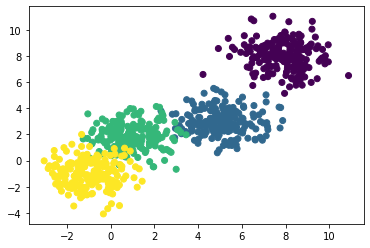

In [34]:
nb_samples = 200
mu_init_z = np.array([[-1,-1],[1,2],[5,3],[8,8]])
nb_clusters = len(mu_init_z)
z,true_clusters = create_z(mu_init_z,nb_samples)
plt.scatter(z[:,0],z[:,1], c = true_clusters)

In [35]:
mat_gaussian = to_Kernel_train(z,GaussianKernel)
mat_linear = to_Kernel_train(z,LinearKernel)
mat_poly = to_Kernel_train(z,PolynomialKernel)

Initilisation : 


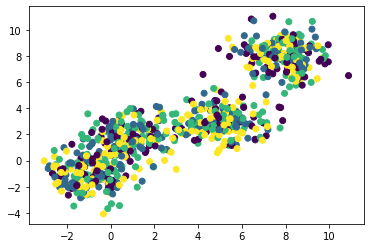

Update : 


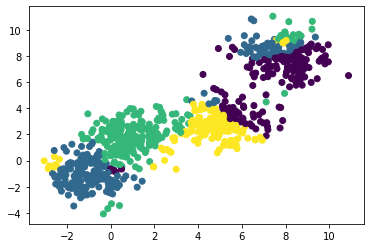

Update : 


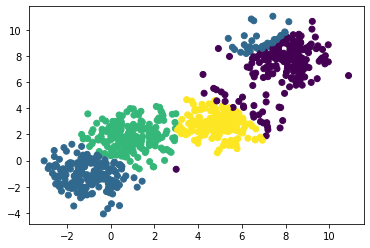

Update : 


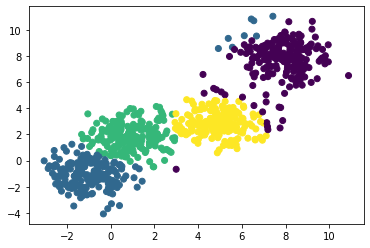

Update : 


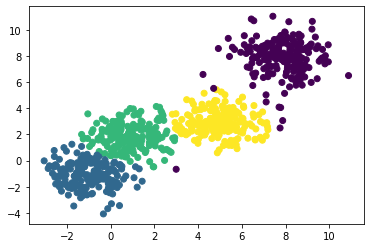

Update : 


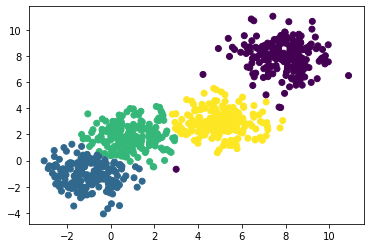

CPU times: user 52.6 s, sys: 1.51 s, total: 54.1 s
Wall time: 52 s


In [38]:
KKM = Unsupervised.KernelKmeans()
%time KKM.fit(mat_gaussian,4,Niter_max=5, z=z)

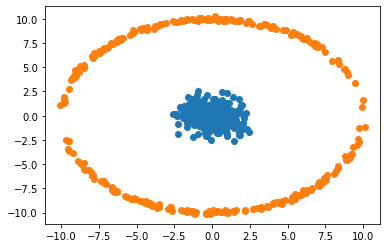

In [39]:
r=100
nb_points = 300
center = np.random.randn(nb_points,2)
outside_x = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r)*np.random.rand(nb_points)
outside_y = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r-outside_x**2)
outside_x += 0.1*np.random.randn(nb_points)
outside_y += 0.1*np.random.randn(nb_points)
plt.scatter(center[:,0],center[:,1])
plt.scatter(outside_x,outside_y)

In [40]:
outside = np.column_stack((outside_x,outside_y))
z_rond = np.concatenate((center,outside))

In [41]:
mat_gaussian_z_rond = to_Kernel_train(z_rond,GaussianKernel)
mat_line_z_rond = to_Kernel_train()

Initilisation : 


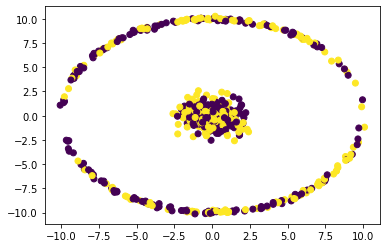

Update : 


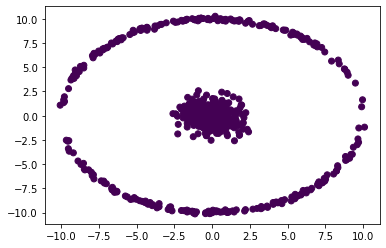

Update : 


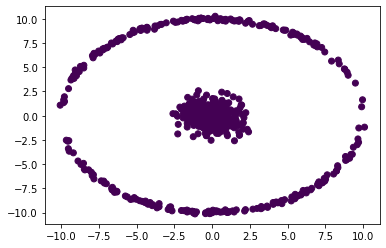

Update : 


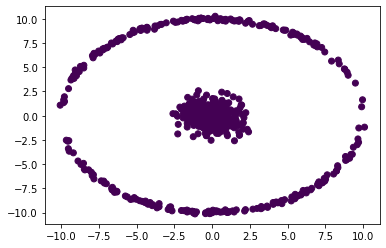

In [53]:
d = 1.1
c = 0
sig2 =1
mat_poly_z_rond = to_Kernel_train(z_rond,PolynomialKernel)

KKM.fit(mat_poly_z_rond,2,Niter_max=3, z=z_rond,viz = True)